# Phase 2 — Two-Qubit Ising Hamiltonian and Trotterization

In Phase 1, we expiremented with a single qubit evolving under a Hamiltonian and observed
the Rabi oscillations. In Phase 2, we move to a **two-qubit** system so
we can explore what happens when qubits **interact** with each other.

The Hilbert space is now four-dimensional with basis  
$\{|00\rangle, |01\rangle, |10\rangle, |11\rangle\}$.

We use the Ising-type Hamiltonian

$$
H = J\,\sigma_{z_1}\sigma_{z_2} + \frac{\Omega}{2}(\sigma_{x_1} + \sigma_{x_2}),
$$

where:

- $J\,\sigma_{z_1}\sigma_{z_2}$ is the **coupling term** (ZZ interaction).
- $\frac{\Omega}{2}(\sigma_{x_1} + \sigma_{x_2})$ are **local X terms** that drive
  transitions on each qubit (similar to Phase 1).

Because the ZZ interaction and the local X terms **do not commute**, we cannot
write the time evolution as a single exponential that factorizes nicely. Instead,
we will approximate the evolution using **Trotterization**.

In this notebook, we will:

1. Construct the exact Hamiltonian matrix $H$ and compute the exact time
   evolution operator  
   $$U_{\text{exact}}(t) = e^{-iHt}.$$

2. Build **first-order** and **second-order** Trotter circuits to approximate
   the evolution for a time step $\Delta t$.

3. Compare Trotterized evolution with the exact evolution and analyze how the
   accuracy depends on the number of Trotter steps.

4. Visualize circuit depths for first and second-order Trotter circuits as
   the number of steps increases.

5. Introduce noise models and observe their impact on the results for both
   Trotter orders.


In [76]:
import numpy as np
from scipy.linalg import expm
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector

# Single-qubit Identity and Pauli matrices
I = np.eye(2, dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Z = np.array([[1,  0], [0, -1]], dtype=complex)

# Function to create necessary two-qubit operators
def two_qubit_operators():
    Z1 = np.kron(Z, I)
    Z2 = np.kron(I, Z)
    X1 = np.kron(X, I)
    X2 = np.kron(I, X)  

    return Z1, Z2, X1, X2

# Function to build the Hamiltonian
def build_hamiltonian(J: float, Omega: float) -> np.ndarray:

    Z1, Z2, X1, X2 = two_qubit_operators()

    H_ZZ = J * (Z1 @ Z2)
    H_local = (Omega / 2) * (X1 + X2)

    H = H_ZZ + H_local

    return H

# Test building the Hamiltonian
H_test = build_hamiltonian(1, 1)
print("Hamiltonian shape:", H_test.shape)
print("Hamiltonian matrix:\n", H_test)

Hamiltonian shape: (4, 4)
Hamiltonian matrix:
 [[ 1. +0.j  0.5+0.j  0.5+0.j  0. +0.j]
 [ 0.5+0.j -1. +0.j  0. +0.j  0.5+0.j]
 [ 0.5+0.j  0. +0.j -1. +0.j  0.5+0.j]
 [ 0. +0.j  0.5+0.j  0.5+0.j  1. +0.j]]


## Exact time evolution for the two-qubit Ising model

Now that we have the Hamiltonian matrix $H$ for our two-qubit system, we can look
at how the state evolves in time.

The exact time evolution operator is

$$
U_{\text{exact}}(t) = e^{-i H t},
$$

Given an initial state $\lvert \psi(0) \rangle$, the state at time $t$ is

$$
\lvert \psi(t) \rangle = U_{\text{exact}}(t)\,\lvert \psi(0) \rangle.
$$

For a two-qubit system in the computational basis
$\{ \lvert 00 \rangle, \lvert 01 \rangle, \lvert 10 \rangle, \lvert 11 \rangle \}$,
we can represent states as 4-component column vectors. For example,

$$
\lvert 00 \rangle =
\begin{pmatrix}
1 \\\\
0 \\\\
0 \\\\
0
\end{pmatrix},
\qquad
\lvert 01 \rangle =
\begin{pmatrix}
0 \\\\
1 \\\\
0 \\\\
0
\end{pmatrix},
\quad \text{etc.}
$$

The code bellow implements the following steps:

1. Construct $U_{\text{exact}}(t)$ by computing the matrix exponential of $-i H t$.
2. Define the four computational basis states $\lvert 00 \rangle, \lvert 01 \rangle,
   \lvert 10 \rangle, \lvert 11 \rangle$.
3. Write a helper function that takes a state vector and returns the measurement
   probabilities for each basis state.


In [77]:
def exact_unitary(t: float, J: float, Omega: float) -> np.ndarray:
    H = build_hamiltonian(J, Omega)
    return expm(-1j * H * t)


# Computational basis states for two-qubits

ket_00 = np.array([1, 0, 0, 0], dtype=complex)
ket_01 = np.array([0, 1, 0, 0], dtype=complex)
ket_10 = np.array([0, 0, 1, 0], dtype=complex)
ket_11 = np.array([0, 0, 0, 1], dtype=complex)


def evolve_state(psi: np.ndarray, t: float, J: float, Omega: float) -> np.ndarray:
    
    U = exact_unitary(t, J, Omega)
    return U @ psi

def state_probabilities(psi: np.ndarray) -> dict:

    probs = np.abs(psi) ** 2 

    labels = ["|00>", "|01>", "|10>", "|11>"]

    return {
        label: float(p) 
        for label, p in zip(labels, probs)
    }



# Test time evolution and probability calculation
psi_t = evolve_state(ket_00, 1, 1, 1)
print(f"Probabilities at t = {1}:")
print(state_probabilities(psi_t))


Probabilities at t = 1:
{'|00>': 0.7140334019346642, '|01>': 0.12196019550786547, '|10>': 0.1219601955078655, '|11>': 0.04204620704960511}


## Exact evolution over time

Up to now, we only looked at what the state looks like at a single time value.
To understand the actual behavior of this two-qubit system, we need to see how
the probabilities of each basis state change **as time evolves**.

The idea is simple:

1. Pick the parameters we want to use (the coupling $J$ and the drive strength $\Omega$).
2. Choose an initial state — here we’ll start with $|00\rangle$.
3. Make a list of time values from $0$ up to some $t_{\max}$.
4. For each time $t$, compute the exact evolved state $|\psi(t)\rangle = U_{\text{exact}}(t)\,|\psi(0)\rangle$.
5. Convert $|\psi(t)\rangle$ into the probabilities of measuring $|00\rangle,\ |01\rangle,\ |10\rangle,\ |11\rangle$.
6. Plot how those probabilities change over time.

This demonstrates:

- how amplitude leaves $|00\rangle$ and moves into $|01\rangle$ and $|10\rangle$,
- and how $|11\rangle$ starts to appear later since it requires **two flips** to reach from $|00\rangle$.


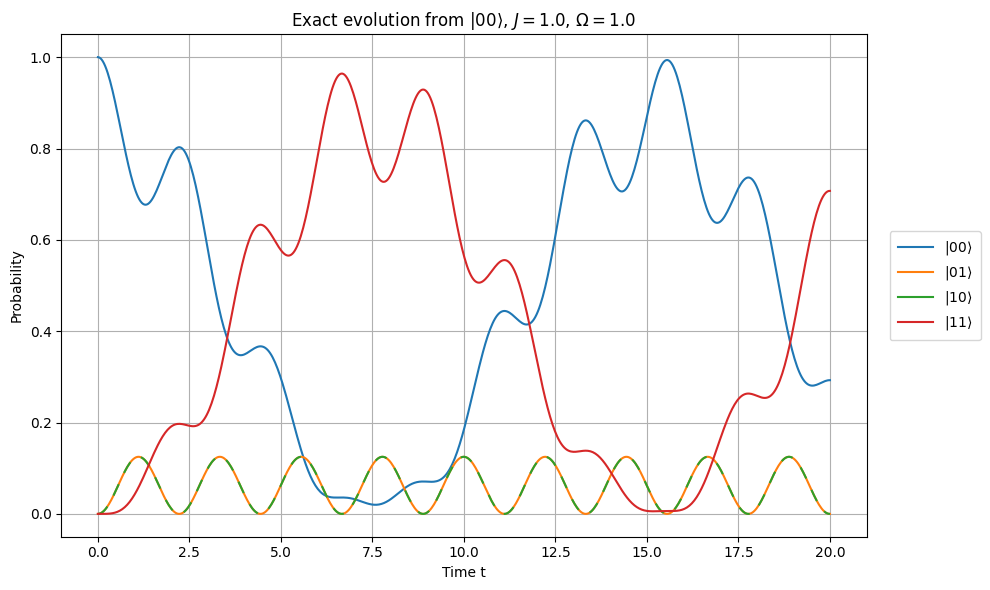

In [78]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def probabilities_over_time(
    psi: np.ndarray,
    J: float,
    Omega: float,
    t_array: np.ndarray,
) -> dict:
    
    probs_00 = []
    probs_01 = []
    probs_10 = []
    probs_11 = []

    for t in t_array:
        psi_t = evolve_state(psi, t, J, Omega)
        probs = state_probabilities(psi_t)

        probs_00.append(probs["|00>"])
        probs_01.append(probs["|01>"])
        probs_10.append(probs["|10>"])
        probs_11.append(probs["|11>"])

    return {
        "|00>": np.array(probs_00),
        "|01>": np.array(probs_01),
        "|10>": np.array(probs_10),
        "|11>": np.array(probs_11),
    }


# Evolution from |00> state

J_val = 1.0
Omega_val = 1.0

t_max = 20.0
num_points = 600
t_grid = np.linspace(0.0, t_max, num_points)

probs_vs_time = probabilities_over_time(ket_00, J_val, Omega_val, t_grid)

plt.figure(figsize=(10, 6))

plt.plot(t_grid, probs_vs_time["|00>"], label=r"$|00\rangle$", color="C0")
plt.plot(t_grid, probs_vs_time["|01>"], label=r"$|01\rangle$", color="C1")
plt.plot(t_grid, probs_vs_time["|10>"], linestyle=(0, (6, 6)), label=r"$|10\rangle$", color="C2")
plt.plot(t_grid, probs_vs_time["|11>"], label=r"$|11\rangle$", color="C3")

plt.xlabel("Time t")
plt.ylabel("Probability")
plt.title(
    fr"Exact evolution from $|00\rangle$, $J = {J_val}$, $\Omega = {Omega_val}$"
)
plt.grid(True)

legend_handles = [
    Line2D([0], [0], color="C0", label=r"$|00\rangle$"),
    Line2D([0], [0], color="C1", label=r"$|01\rangle$"),
    Line2D([0], [0], color="C2", label=r"$|10\rangle$"),
    Line2D([0], [0], color="C3", label=r"$|11\rangle$"),
]

plt.legend(
    handles=legend_handles,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    borderpad=0.6,
    handlelength=2.5,
)
plt.tight_layout()
plt.show()




## First-order Trotterization of the Ising Hamiltonian

Above, we have been using the “exact” time evolution operator

$$
U_{\text{exact}}(t) = e^{-iHt},
$$

which we compute using the full Hamiltonian matrix and a matrix exponential.
That gives us the true evolution for the system, but it’s not something a real
quantum device can apply directly. Hardware only uses smaller, local gates.

To get something a quantum circuit *can* implement, we break the Hamiltonian into
two pieces:

$$
H = H_{ZZ} + H_X,
$$

where

$$
H_{ZZ} = J\,\sigma_{z_1}\sigma_{z_2}, \qquad
H_X = \frac{\Omega}{2}(\sigma_{x_1} + \sigma_{x_2}).
$$

These two parts don’t commute, which means we can’t just exponentiate them
separately and multiply the results. So we solve this by using **Trotterization**.

Instead of evolving for the full time $t$ in one shot, we split the
time into $n$ small steps of size

$$
\Delta t = \frac{t}{n},
$$

and approximate the evolution using

$$
S_{1}(t) \approx
\left[
  e^{-i H_{ZZ} \Delta t}\,
  e^{-i H_X \Delta t}
\right]^n.
$$

Each bracketed pair is one **Trotter step**. In circuit terms:

- $e^{-i H_{ZZ} \Delta t}$ becomes a two-qubit $ZZ$ rotation.
- $e^{-i H_X \Delta t}$ becomes single-qubit $X$ rotations on both qubits.

In the next cell, we build one Trotter step using Qiskit, then repeat it $n$
times to approximate the full evolution for time $t$.


In [79]:
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Operator

def trotter_step_first_order(J: float, Omega: float, dt: float) -> QuantumCircuit:

    qc = QuantumCircuit(2)

    # Coupling term of the Hamiltonian
    qc.rzz(2.0 * J * dt, 0, 1)

    # Local Terms of the Hamiltonian
    qc.rx(Omega * dt, 0)
    qc.rx(Omega * dt, 1)

    return qc


def trotter_circuit_first_order(J: float, Omega: float, t: float, n_steps: int) -> QuantumCircuit:

    qc = QuantumCircuit(2)

    dt = t / n_steps

    step = trotter_step_first_order(J, Omega, dt)

    # Apply the same step n_steps times
    for _ in range(n_steps):
        qc.compose(step, inplace=True)

    return qc


# Test different step count for Trotter circuit against exact unitary

J_test = 1.0
Omega_test = 1.0
t_test = 1.0
# Increase n_steps_test to see better approximation
n_steps_test = 10

qc_trot = trotter_circuit_first_order(J_test, Omega_test, t_test, n_steps_test)

U_trot = Operator(qc_trot).data
U_exact = exact_unitary(t_test, J_test, Omega_test)

diff_norm = np.linalg.norm(U_trot - U_exact)
print("Trotter Error =", diff_norm)


Trotter Error = 0.09892554275294793


## How Trotter error changes with the number of steps

Here we fix $J$, $\Omega$, and the total evolution time $t$, and only change the
number of Trotter steps $n$.

For each $n$:

- we build the first-order Trotter circuit for time $t$,
- convert it to a unitary $S_{1}(t)$,
- compare it to the exact unitary $U_{\text{exact}}(t)$ by calculating the norm of the difference.

The plot shows how this error decreases as we increase $n$. More steps means
smaller time slices and a better approximation, but it also means a deeper
circuit, which we will become problematic when we introduce noise created from things such as gate fidelity, amplitude and phase damping, and measurement.


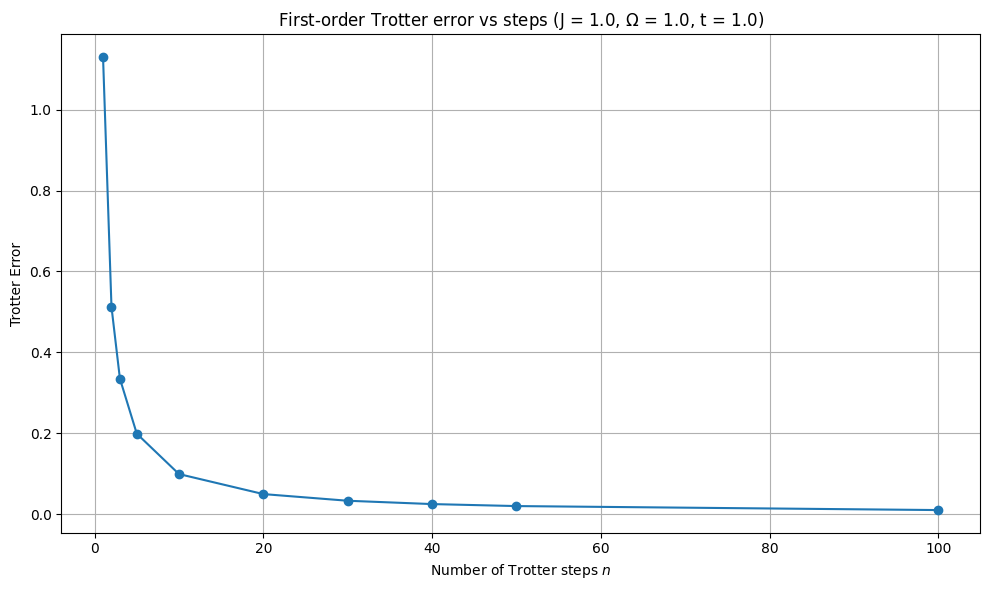

n =   1,  error = 1.1303e+00
n =   2,  error = 5.1253e-01
n =   3,  error = 3.3478e-01
n =   5,  error = 1.9875e-01
n =  10,  error = 9.8926e-02
n =  20,  error = 4.9407e-02
n =  30,  error = 3.2931e-02
n =  40,  error = 2.4696e-02
n =  50,  error = 1.9757e-02
n = 100,  error = 9.8778e-03


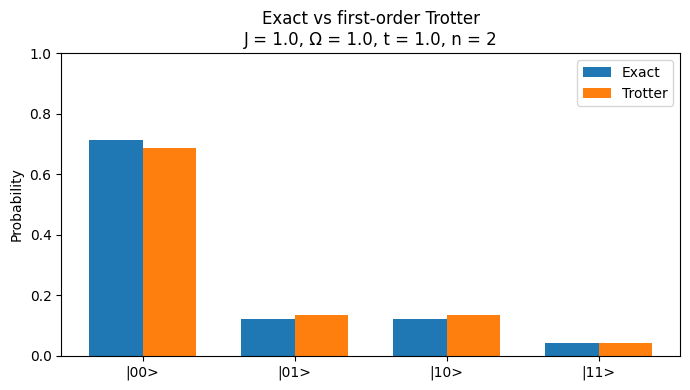

Exact probabilities:
{'|00>': 0.7140334019346642, '|01>': 0.12196019550786547, '|10>': 0.1219601955078655, '|11>': 0.04204620704960511}

Trotter probabilities:
{'|00>': 0.6866507555702674, '|01>': 0.13633088986133962, '|10>': 0.13633088986133962, '|11>': 0.04068746470705312}


In [80]:
def evolve_state_trotter(psi: np.ndarray, J: float, Omega: float, t: float, n_steps: int) -> np.ndarray:

    qc_trot = trotter_circuit_first_order(J, Omega, t, n_steps)
    U_trot = Operator(qc_trot).data
    return U_trot @ psi

def trotter_step_error(J: float, Omega: float, t: float, steps_list):

    errors = []

    U_exact = exact_unitary(t, J, Omega)

    for n in steps_list:
        qc_trot = trotter_circuit_first_order(J, Omega, t, n)
        U_trot = Operator(qc_trot).data

        # Approximation error
        diff = U_trot - U_exact
        err = np.linalg.norm(diff)
        errors.append(err)

    return np.array(errors)


# Choose parameters and a range of Trotter steps
J_val = 1.0
Omega_val = 1.0
t_val = 1.0

steps_list = [1, 2, 3, 5, 10, 20, 30, 40, 50, 100]

errors = trotter_step_error(J_val, Omega_val, t_val, steps_list)

plt.figure(figsize=(10, 6))
plt.plot(steps_list, errors, marker="o")
plt.xlabel("Number of Trotter steps $n$")
plt.ylabel("Trotter Error")
plt.title(
    rf"First-order Trotter error vs steps (J = {J_val}, $\Omega$ = {Omega_val}, t = {t_val})"
)
plt.grid(True)
plt.tight_layout()
plt.show()


for n, err in zip(steps_list, errors):
    print(f"n = {n:3d},  error = {err:.4e}")


# Compare exact and Trotter-evolved states at single time point

n_steps = 2
# Exact and Trotter-evolved states
psi_exact = evolve_state(ket_00, t_val, J_val, Omega_val)
psi_trot = evolve_state_trotter(ket_00, J_val, Omega_val, t_val, n_steps)

probs_exact = state_probabilities(psi_exact)
probs_trot = state_probabilities(psi_trot)

# Bar plot

labels = ["|00>", "|01>", "|10>", "|11>"]
exact_vals = [probs_exact[label] for label in labels]
trot_vals = [probs_trot[label] for label in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar(x - width / 2, exact_vals, width, label="Exact")
plt.bar(x + width / 2, trot_vals, width, label="Trotter")

plt.xticks(x, labels)
plt.ylim(0, 1.0)
plt.ylabel("Probability")
plt.title(
    f"Exact vs first-order Trotter\n"
    f"J = {J_val}, Ω = {Omega_val}, t = {t_val}, n = {n_steps}"
)
plt.legend()
plt.tight_layout()
plt.show()

print("Exact probabilities:")
print(probs_exact)
print("\nTrotter probabilities:")
print(probs_trot)


## Exact vs Trotter probabilities over time

Next we compare the exact evolution to the Trotter approximation across an entire
time window, not just at a single point. This makes it easier to see how well
(first-order) Trotter actually tracks the real dynamics.

A key thing to notice is that **Trotter error grows over time**. If the number of
steps $n$ is too small, the Trotter curves will drift away from the exact ones
as $t$ increases. With a larger $n$, the approximation stays much closer.

We focus on the $|00\rangle$ and $|11\rangle$ probabilities, since most of the
population moves between those two states in this model.

Try changing the number of Trotter steps `n_steps` to see how it affects the accuracy!

Increasing `t_max` will also highlight how Trotter error accumulates over longer times.

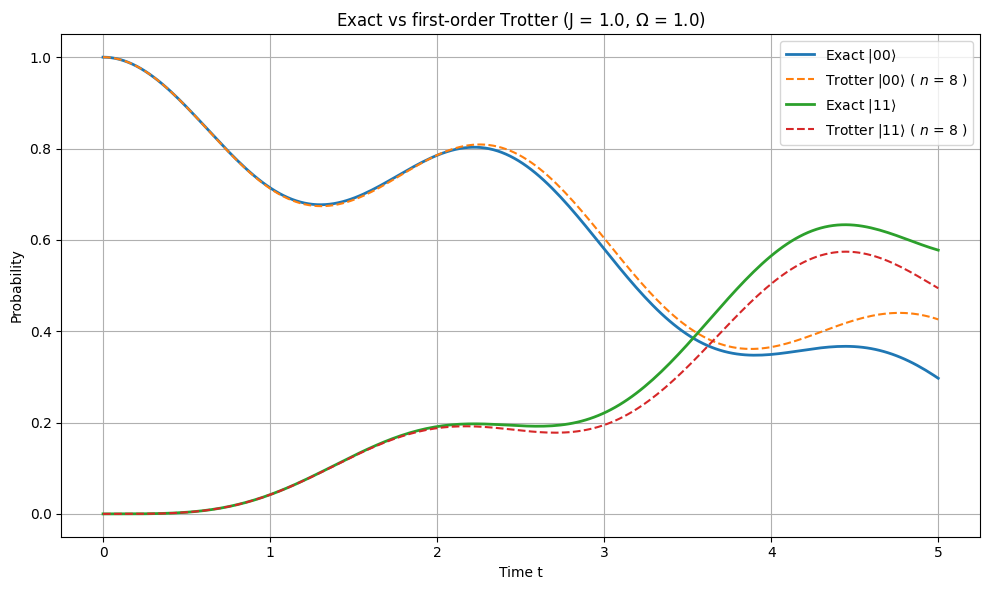

In [81]:
import matplotlib.pyplot as plt

def probabilities_over_time_trotter(
    psi: np.ndarray,
    J: float,
    Omega: float,
    t_array: np.ndarray,
    n_steps: int,
):

    probs_00 = []
    probs_11 = []

    for t in t_array:

        psi_t = evolve_state_trotter(psi, J, Omega, t, n_steps)
        probs = state_probabilities(psi_t)

        probs_00.append(probs["|00>"])
        probs_11.append(probs["|11>"])

    return {
        "|00>": np.array(probs_00),
        "|11>": np.array(probs_11),
    }


# Compare exact unitary vs Trotter unitary over time

J_plot = 1.0
Omega_plot = 1.0

t_max = 5.0
num_points = 200
t_grid = np.linspace(0.0, t_max, num_points)

# Exact probabilities
probs_exact = probabilities_over_time(ket_00, J_plot, Omega_plot, t_grid)

# Choose a Trotter step count to compare

n_steps = 8  # try changing this to see impact on accuracy

probs_trot = probabilities_over_time_trotter(
    ket_00, J_plot, Omega_plot, t_grid, n_steps
)

plt.figure(figsize=(10, 6))

# |00> curves
plt.plot(
    t_grid,
    probs_exact["|00>"],
    label=r"Exact $|00\rangle$",
    linewidth=2,
)
plt.plot(
    t_grid,
    probs_trot["|00>"],
    "--",
    label=fr"Trotter $|00\rangle$ ( $n$ = {n_steps} )",
)

# |11> curves
plt.plot(
    t_grid,
    probs_exact["|11>"],
    label=r"Exact $|11\rangle$",
    linewidth=2,
)
plt.plot(
    t_grid,
    probs_trot["|11>"],
    "--",
    label=fr"Trotter $|11\rangle$ ( $n$ = {n_steps} )",
)

plt.xlabel("Time t")
plt.ylabel("Probability")
plt.title(
    fr"Exact vs first-order Trotter (J = {J_plot}, $\Omega$ = {Omega_plot})"
)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Impact of step count on probability error over time

To see how the Trotter approximation improves as we increase the number of
steps $n$, We compare the exact $|11\rangle$ probability to the Trotter
result and define the pointwise probability error
$$
E_n(t) = \bigl|P_{11}^{\text{trotter}}(t;n) - P_{11}^{\text{exact}}(t)\bigr|.
$$

For each $n$, draw a band around the exact curve.

The width of this band shows **how far the Trotter curve is from the exact
operator dynamics** at each time. Narrower band means better accuracy as $n$ increases.

Note: the Trotter trajectory for each $n$ is a single deterministic curve.
The band does not represent randomness It simply visualizes the size of the
approximation error over time.


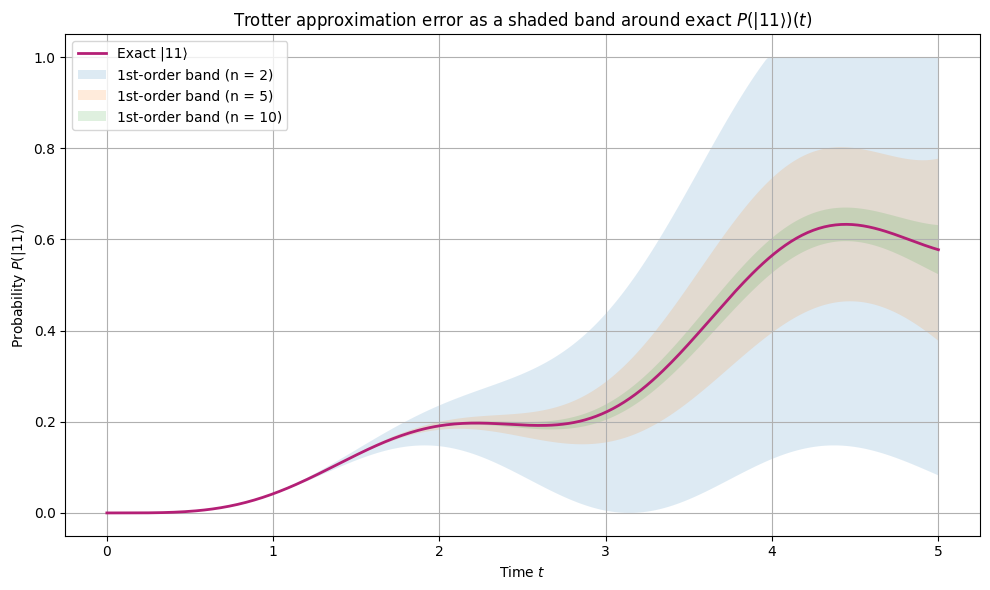

In [82]:
J_ribbon = 1.0
Omega_ribbon = 1.0
t_max_ribbon = 5.0
num_points_ribbon = 300
t_grid_ribbon = np.linspace(0.0, t_max_ribbon, num_points_ribbon)

# Exact evolution probabilities
probs_exact_ribbon = probabilities_over_time(ket_00, J_ribbon, Omega_ribbon, t_grid_ribbon)
P11_exact = probs_exact_ribbon["|11>"]

# step value options
n_values = [2, 5, 10]

plt.figure(figsize=(10, 6))

# Plot exact curve once
plt.plot(t_grid_ribbon, P11_exact, label="Exact |11⟩", color="#b41f76", linewidth=2)

for n in n_values:
    probs_trot = probabilities_over_time_trotter(
        ket_00, J_ribbon, Omega_ribbon, t_grid_ribbon, n
    )
    P11_trot = probs_trot["|11>"]
    error = np.abs(P11_trot - P11_exact)

    lower = np.clip(P11_exact - error, 0.0, 1.0)
    upper = np.clip(P11_exact + error, 0.0, 1.0)

    plt.fill_between(
        t_grid_ribbon,
        lower,
        upper,
        alpha=0.15,
        label=f"1st-order band (n = {n})",
        step=None,
    )

plt.xlabel("Time $t$")
plt.ylabel("Probability $P(|11⟩)$")
plt.title("Trotter approximation error as a shaded band around exact $P(|11⟩)(t)$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Second-order Trotterization (Suzuki–Trotter)

First-order Trotter splits the evolution as  

$$
e^{-i(H_{ZZ} + H_X)t} \approx e^{-iH_{ZZ}\Delta t}\, e^{-iH_X\Delta t},
$$

but the error only decreases linearly with the number of steps.

Second-order Trotter improves this by using a symmetric sequence:

$$
S_{2}(\Delta t)
= e^{-i H_{ZZ} \frac{\Delta t}{2}}
  e^{-i H_X \Delta t}
  e^{-i H_{ZZ} \frac{\Delta t}{2}}.
$$

Repeating this block $n$ times gives a much better approximation to the exact
evolution for the same total simulated time. In other words, second-order
Trotter gets you higher accuracy without needing as many steps. The trade-off is that the circuit for each step is slightly deeper.


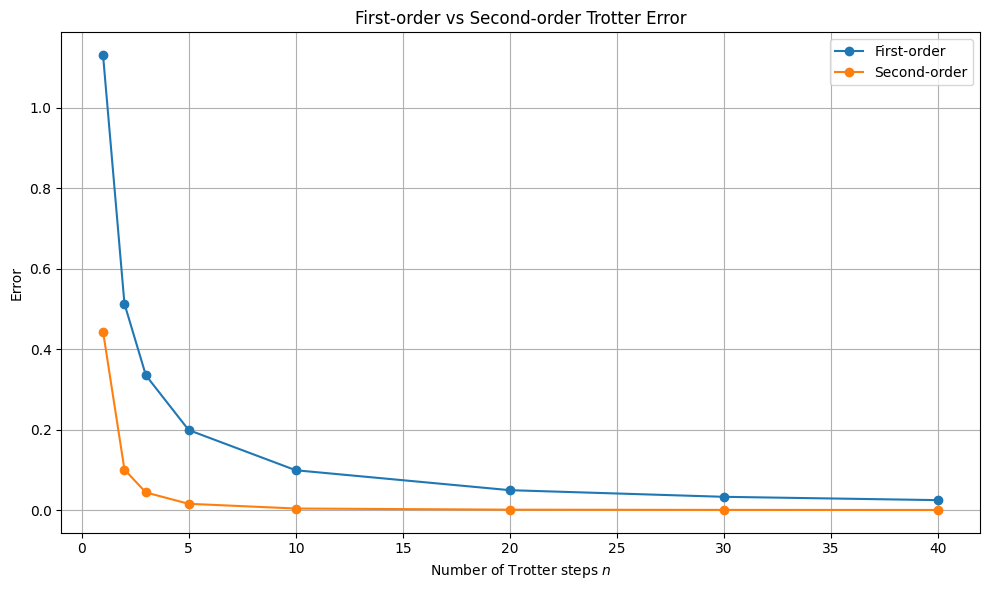

In [83]:
def trotter_step_second_order(J: float, Omega: float, dt: float) -> QuantumCircuit:

    qc = QuantumCircuit(2)

    # First coupling term
    qc.rzz(2.0 * J * (dt / 2), 0, 1)

    # Local X term
    qc.rx(Omega * dt, 0)
    qc.rx(Omega * dt, 1)

    # Second coupling term
    qc.rzz(2.0 * J * (dt / 2), 0, 1)

    return qc


def trotter_circuit_second_order(J: float, Omega: float, t: float, n_steps: int) -> QuantumCircuit:

    dt = t / n_steps

    qc = QuantumCircuit(2)

    step = trotter_step_second_order(J, Omega, dt)

    for _ in range(n_steps):
        qc.compose(step, inplace=True)

    return qc


# Compare first-order and second-order Trotter errors
J_val = 1.0
Omega_val = 1.0
t_val = 1.0

steps_list = [1, 2, 3, 5, 10, 20, 30, 40]
errs_first = []
errs_second = []

U_exact = exact_unitary(t_val, J_val, Omega_val)

for n in steps_list:
    U1 = Operator(trotter_circuit_first_order(J_val, Omega_val, t_val, n)).to_matrix()
    U2 = Operator(trotter_circuit_second_order(J_val, Omega_val, t_val, n)).to_matrix()
    errs_first.append(np.linalg.norm(U1 - U_exact))
    errs_second.append(np.linalg.norm(U2 - U_exact))


plt.figure(figsize=(10, 6))
plt.plot(steps_list, errs_first, "o-", label="First-order")
plt.plot(steps_list, errs_second, "o-", label="Second-order")
plt.xlabel("Number of Trotter steps $n$")
plt.ylabel("Error")
plt.title("First-order vs Second-order Trotter Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Circuit complexity vs Trotter order

One of the main trade-offs in Trotterization is the choice between **first-order**
and **second-order** formulas. Second-order Trotter generally gives a much better
approximation to the exact evolution for the same number of steps \(n\), but the
cost is that each Trotter step contains *more gates* and leads to a noticeably
*deeper* circuit.

This trade-off is an important consideration when designing quantum algorithms for quantum hardware.


### Visualizing first and second order Trotter circuits

First-order Trotter circuit:


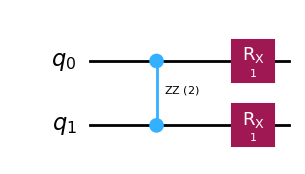

Second-order Trotter circuit:


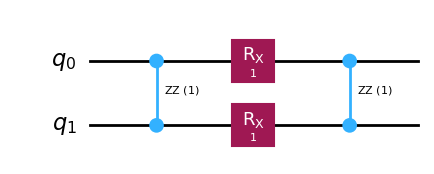

In [84]:
n = 1
J = 1.0
Omega = 1.0
t = 1.0

trotter1_circuit = trotter_circuit_first_order(J, Omega, t, n)
trotter2_circuit = trotter_circuit_second_order(J, Omega, t, n)

print("First-order Trotter circuit:")
display(trotter1_circuit.draw("mpl"))
print("Second-order Trotter circuit:")
display(trotter2_circuit.draw("mpl"))   

### Rate of change of circuit depth with Trotter steps
first order trotter has a depth that increases at a rate of 2 per step, while second order trotter has a depth that increases at a rate of 3 per step.

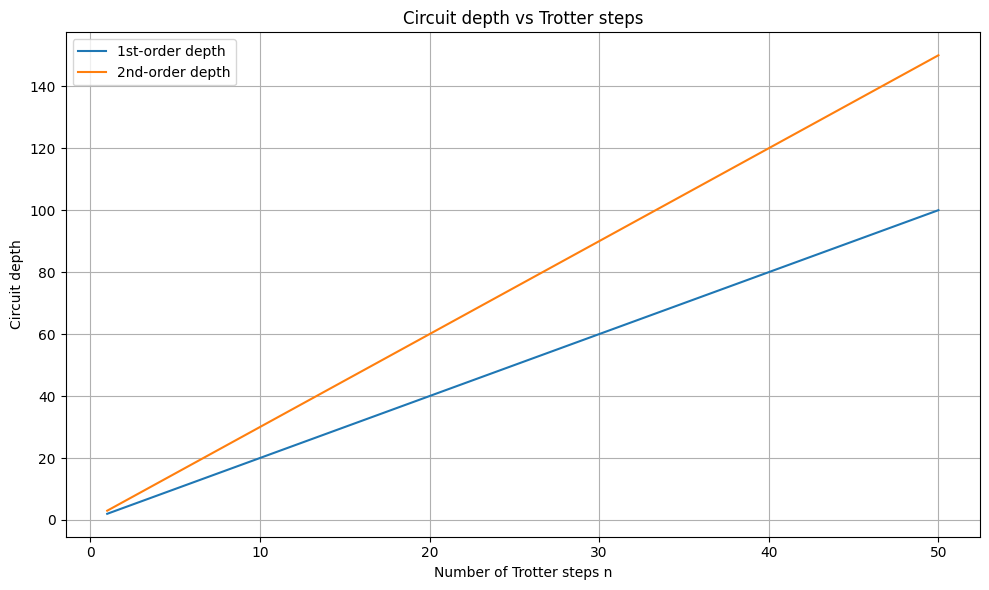

In [85]:
# Circuit complexity vs Trotter steps

J_complex = 1.0
Omega_complex = 1.0
t_total = 5.0
n_steps_list = list(range(1, 51))

depths_1 = []
depths_2 = []

for n in n_steps_list:
    # First-order circuit
    trotter1_circuit = trotter_circuit_first_order(J_complex, Omega_complex, t_total, n)
    depths_1.append(trotter1_circuit.depth())

    # Second-order circuit
    trotter2_circuit = trotter_circuit_second_order(J_complex, Omega_complex, t_total, n)
    depths_2.append(trotter2_circuit.depth())

plt.figure(figsize=(10, 6))
plt.plot(n_steps_list, depths_1, label="1st-order depth")
plt.plot(n_steps_list, depths_2, label="2nd-order depth")
plt.xlabel("Number of Trotter steps n")
plt.ylabel("Circuit depth")
plt.title("Circuit depth vs Trotter steps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Noisy First and Second Order Trotter Simulation

So far we’ve only looked at ideal simulations where all gates and measurements 
are perfect. To make things more realistic and introduce complexities that arise 
in real hardware, we build a noise model that captures three
major types of hardware errors:

- **Gate noise** (using depolarizing channels on RX and RZZ gates)  
- **Coherence effects** (amplitude damping and phase damping)  
- **Measurement noise** (the readout can flip 0 ↦ 1 or 1 ↦ 0 with small probability)

We will calculate the probabilities over time for the following cases:
- **Exact** evolution (ground truth)  
- **Noiseless Trotter** (approximation error only)  
- **Noisy Trotter** (approximation error + hardware-like noise)

The plots below show the probability of $|11⟩$ for each case, for both first-order and second-order Trotter simulations.


### Build Ising noise model
Build a noise model that includes gate errors, coherence effects, and measurement noise.

In [86]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    depolarizing_error,
    amplitude_damping_error,
    phase_damping_error,
    ReadoutError,
)
from qiskit import ClassicalRegister, transpile

# Build Ising noise model
def ising_noise_model(
    p_1q: float = 0.002,
    p_2q: float = 0.01,
    gamma_1q: float = 0.001,
    lambda_1q: float = 0.002,
    p_measure: float = 0.02,
) -> NoiseModel:

    noise_model = NoiseModel()

    # 1-qubit gate and coherence noise on local term
    dep_1q = depolarizing_error(p_1q, 1)
    amp_1q = amplitude_damping_error(gamma_1q)
    phase_1q = phase_damping_error(lambda_1q)

    # compose the errors
    err_1q = amp_1q.compose(phase_1q).compose(dep_1q)
    noise_model.add_all_qubit_quantum_error(err_1q, ["rx"])

    # 2-qubit gate noise for coupling term
    dep_2q = depolarizing_error(p_2q, 2)

    # Build 2-qubit versions of the decoherence errors
    amp_2q = amp_1q.tensor(amp_1q)
    phase_2q = phase_1q.tensor(phase_1q)

    # compose the errors
    err_2q = amp_2q.compose(phase_2q).compose(dep_2q)
    noise_model.add_all_qubit_quantum_error(err_2q, ["rzz"])

    # Measurement (readout) error
    ro_matrix = [
        [1 - p_measure, p_measure],
        [p_measure, 1 - p_measure],  
    ]
    readout_error = ReadoutError(ro_matrix)
    noise_model.add_all_qubit_readout_error(readout_error)

    return noise_model

### First-Order Trotter Helper Functions
Helper functions to build first-order Trotter circuits and run noisy simulations.

In [87]:
# First order trotter circuit with measurements
def trotter_circuit_with_measurements(
    J: float,
    Omega: float,
    t: float,
    n_steps: int,
) -> QuantumCircuit:

    qc = trotter_circuit_first_order(J, Omega, t, n_steps)

    reg = ClassicalRegister(2, "c")
    qc.add_register(reg)
    qc.measure([0, 1], [0, 1])

    return qc

# Calculating probabilities over time with noise for first order trotter
def noisy_trotter1_prob_over_time(
    J: float,
    Omega: float,
    t_array: np.ndarray,
    n_steps: int,
    shots: int = 20_000,
):

    noise_model = ising_noise_model()
    backend = AerSimulator(noise_model=noise_model)

    # Prepare lists for each basis state
    probs_00 = []
    probs_01 = []
    probs_10 = []
    probs_11 = []

    for t in t_array:
        qc = trotter_circuit_with_measurements(J, Omega, t, n_steps)
        qc_compiled = transpile(qc, backend)

        result = backend.run(qc_compiled, shots=shots).result()
        counts = result.get_counts()

        total = sum(counts.values())
        if total == 0:
            p00 = p01 = p10 = p11 = 0.0
        else:
            p00 = counts.get("00", 0) / total
            p01 = counts.get("01", 0) / total
            p10 = counts.get("10", 0) / total
            p11 = counts.get("11", 0) / total

        probs_00.append(p00)
        probs_01.append(p01)
        probs_10.append(p10)
        probs_11.append(p11)

    return {
        "|00>": np.array(probs_00),
        "|01>": np.array(probs_01),
        "|10>": np.array(probs_10),
        "|11>": np.array(probs_11),
    }


### Second-Order Trotter Helper Functions
Helper functions to build second-order Trotter circuits and run noisy simulations.

In [88]:
def probabilities_over_time_trotter2(
    psi: np.ndarray,
    J: float,
    Omega: float,
    t_array: np.ndarray,
    n_steps: int,
):

    probs_00 = []
    probs_11 = []

    for t in t_array:
        qc = trotter_circuit_second_order(J, Omega, t, n_steps)
        U = Operator(qc).to_matrix()
        psi_t = U @ psi
        probs = state_probabilities(psi_t)

        probs_00.append(probs["|00>"])
        probs_11.append(probs["|11>"])

    return {
        "|00>": np.array(probs_00),
        "|11>": np.array(probs_11),
    }

def trotter2_circuit_with_measurements(
    J: float,
    Omega: float,
    t: float,
    n_steps: int,
) -> QuantumCircuit:

    qc = trotter_circuit_second_order(J, Omega, t, n_steps)

    reg = ClassicalRegister(2, "c")
    qc.add_register(reg)
    qc.measure([0, 1], [0, 1])

    return qc


def noisy_trotter2_probabilities_over_time(
    J: float,
    Omega: float,
    t_array: np.ndarray,
    n_steps: int,
    shots: int = 20_000,
):

    noise_model = ising_noise_model()
    backend = AerSimulator(noise_model=noise_model)

    probs_00, probs_01, probs_10, probs_11 = [], [], [], []

    for t in t_array:
        qc = trotter2_circuit_with_measurements(J, Omega, t, n_steps)
        qc_compiled = transpile(qc, backend)

        result = backend.run(qc_compiled, shots=shots).result()
        counts = result.get_counts()

        total = sum(counts.values())
        if total == 0:
            p00 = p01 = p10 = p11 = 0.0
        else:
            p00 = counts.get("00", 0) / total
            p01 = counts.get("01", 0) / total
            p10 = counts.get("10", 0) / total
            p11 = counts.get("11", 0) / total

        probs_00.append(p00)
        probs_01.append(p01)
        probs_10.append(p10)
        probs_11.append(p11)

    return {
        "|00>": np.array(probs_00),
        "|01>": np.array(probs_01),
        "|10>": np.array(probs_10),
        "|11>": np.array(probs_11),
    }

### Plot Noisy First and Second Order Trotter Results
Plot the results of noisy first-order and second-order Trotter simulations alongside exact and noiseless Trotter results.

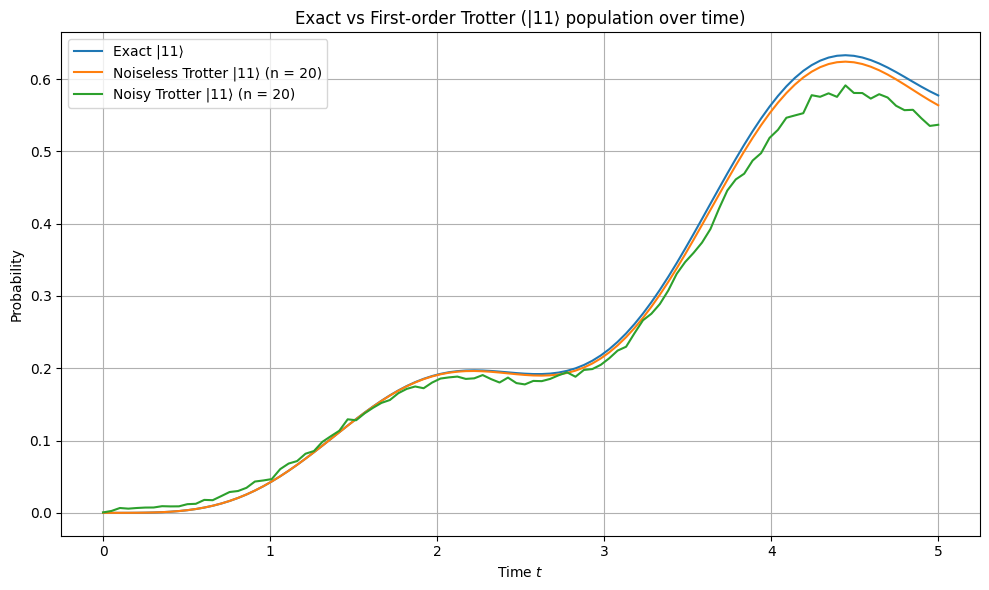

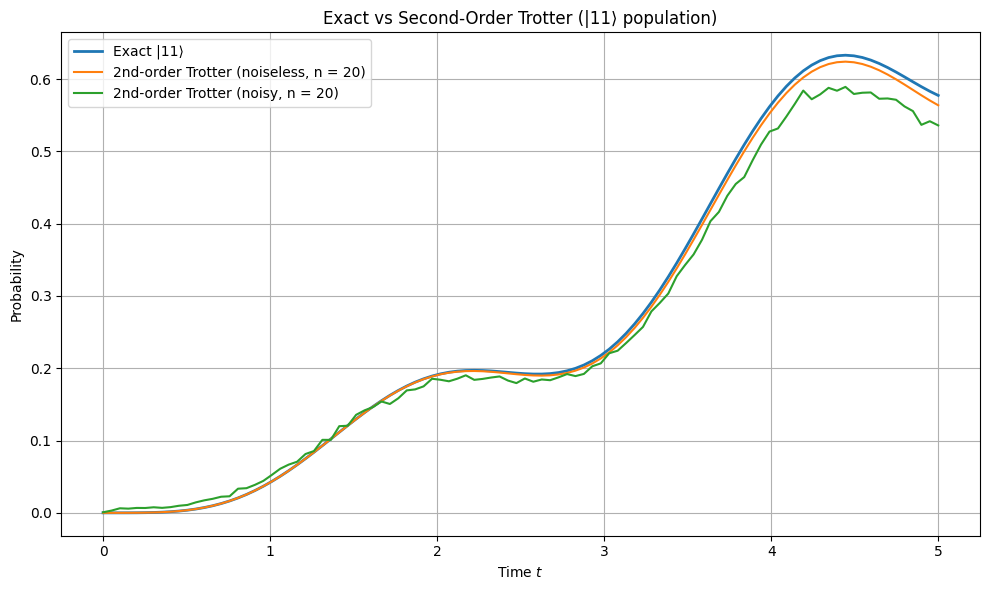

In [89]:
# Hyperparameters for noise comparison. Experiment with these values and 
# observe impact on the results.
J_val = 1.0
Omega_val = 1.0
t_max = 5
num_points = 100
t_grid = np.linspace(0.0, t_max, num_points)
n_steps = 20
shots = 10_000

# Exact evolution probabilities
probs_exact = probabilities_over_time(ket_00, J_val, Omega_val, t_grid)
# Noiseless first-order Trotter probabilities
probs_trotter = probabilities_over_time_trotter(
    ket_00, J_val, Omega_val, t_grid, n_steps
)
# Noisy first-order Trotter probabilities 
probs_noisy = noisy_trotter1_prob_over_time(
    J_val, Omega_val, t_grid, n_steps, shots=shots
)
# Noiseless second-order Trotter probabilities
probs_trotter2 = probabilities_over_time_trotter2(
    ket_00, J_val, Omega_val, t_grid, n_steps
)
# Noisy second-order Trotter probabilities
probs_trotter2_noisy = noisy_trotter2_probabilities_over_time(
    J_val, Omega_val, t_grid, n_steps, shots=shots
)

# Plotting first and second order Trotter with noise

# Plot 1: first-order
plt.figure(figsize=(10, 6))

plt.plot(t_grid, probs_exact["|11>"], label="Exact |11⟩")
plt.plot(
    t_grid,
    probs_trotter["|11>"],
    label=f"Noiseless Trotter |11⟩ (n = {n_steps})",
)
plt.plot(
    t_grid,
    probs_noisy["|11>"],
    label=f"Noisy Trotter |11⟩ (n = {n_steps})",
)

plt.xlabel("Time $t$")
plt.ylabel("Probability")
plt.title("Exact vs First-order Trotter (|11⟩ population over time)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: second-order
plt.figure(figsize=(10, 6))

plt.plot(t_grid, probs_exact["|11>"], label="Exact |11⟩", linewidth=2)
plt.plot(
    t_grid,
    probs_trotter2["|11>"],
    label=f"2nd-order Trotter (noiseless, n = {n_steps})",
)
plt.plot(
    t_grid,
    probs_trotter2_noisy["|11>"],
    label=f"2nd-order Trotter (noisy, n = {n_steps})",
)

plt.xlabel("Time $t$")
plt.ylabel("Probability")
plt.title("Exact vs Second-Order Trotter (|11⟩ population)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Phase 2 Summary

Phase 2 examined the dynamics of a two-qubit Ising Hamiltonian and demonstrated
how continuous-time evolution can be approximated using
Trotterization. Beginning with the exact Ising Hamiltonian

$$
H = J\,\sigma_{z_1}\sigma_{z_2} + \frac{\Omega}{2}(\sigma_{x_1} + \sigma_{x_2}),
$$

and used it to compute the exact time-evolution of the system. This let us see
how probability moves through the four possible basis states and gave us a
baseline for comparison.

We then built **first-order** and **second-order** Trotter approximations.  
First-order Trotter breaks the Hamiltonian into a coupling $ZZ$ part and a local $X$ part and
applies them in sequence. Second-order uses a symmetric version of this sequence
and is more accurate for the same number of steps.

To measure accuracy, we compared each Trotterized unitary to the exact unitary,
and we also looked at how well the Trotter circuits reproduced the probability
of $|11\rangle$ over time. The probability-error “ribbon plot” helped show how
increasing the number of Trotter steps makes the approximation track the exact
curve more closely.

We also looked at **circuit depth**, since deeper circuits mean more gates and
more opportunities for noise. Second-order Trotter had better accuracy but deeper
circuits, which illustrates the trade-off between precision and cost.

Finally, to connect these idealized results to realistic hardware behavior, we
introduced a noise model that includes gate errors, decoherence, and measurement
errors. Comparing exact, noiseless Trotter, and noisy Trotter showed that noise
can pull the dynamics away from the ideal evolution, especially when circuits
become deeper. This also showed why increasing the number of Trotter steps is not
always beneficial on real devices.

Overall, Phase 2 showed three core ideas:

- how the two-qubit Ising Hamiltonian evolves over time,  
- how Trotterization approximates this evolution using gate-based circuits, and  
- how accuracy, circuit depth, and noise trade off with each other in practical
  quantum simulations.

These ideas set the foundation for understanding why quantum simulation is
challenging on current hardware and why higher-order methods or larger step
counts don’t always lead to better results in practice.
